anitaostroumov@gmail.com אניטה אוסטרואומוב  310500160
asaf.ach@gmail.com אסף אחי מרדכי 035892306

# Word Embedding - Home Assigment
## Dr. Omri Allouche 2018. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/deep_learning_course/blob/master/DL_word_embedding_assignment.ipynb)
    
    
In this exercise, you'll use word vectors trained on a corpus of 380,000 lyrics of songs from MetroLyrics (https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics).  
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

## Google Colab

First we'll download the data from Kaggle. For that let's follow the following [Stackoveflow answer](https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab)

In [0]:
# Let's run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anitaos","key":"c142ea5d07f5f0067ac528759292a6a5"}'}

In [0]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 63 Oct 25 06:43 kaggle.json


In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# List available datasets.
!kaggle datasets list

ref                                                      title                                               size  lastUpdated          downloadCount  
-------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
tristan581/17k-apple-app-store-strategy-games            17K Mobile Strategy Games                            8MB  2019-08-26 08:22:16           6665  
gustavomodelli/forest-fires-in-brazil                    Forest Fires in Brazil                              31KB  2019-08-24 16:09:16           7803  
akhilv11/border-crossing-entry-data                      Border Crossing Entry Data                           3MB  2019-08-21 14:51:34           3096  
rajeevw/ufcdata                                          UFC-Fight historical data from 1993 to 2019          2MB  2019-07-05 09:58:02           4350  
shuyangli94/food-com-recipes-and-user-interactions       Food.com Recipes and Interactio

In [0]:
# Copy the MetroLyrics data set locally.
!kaggle datasets download -d gyani95/380000-lyrics-from-metrolyrics

 93% 89.0M/95.6M [00:03<00:00, 22.7MB/s]
100% 95.6M/95.6M [00:03<00:00, 32.1MB/s]


In [0]:
!ls .

380000-lyrics-from-metrolyrics.zip  kaggle.json  sample_data


In [0]:
!unzip 380000-lyrics-from-metrolyrics.zip

Archive:  380000-lyrics-from-metrolyrics.zip
  inflating: lyrics.csv              


In [0]:
!head lyrics.csv

index,song,year,artist,genre,lyrics
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?
You know I'm gonna cut right to the chase
Some women were made but me, myself
I like to think that I was created for a special purpose
You know, what's more special than you? You feel me
It's on baby, let's get lost
You don't need to call into work 'cause you're the boss
For real, want you to show me how you feel
I consider myself lucky, that's a big deal


## Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [0]:
import re
import pandas as pd
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [0]:
# Load the data
raw_data = pd.read_csv("380000-lyrics-from-metrolyrics.zip")

Let's see the data

In [0]:
raw_data.columns.values

array(['index', 'song', 'year', 'artist', 'genre', 'lyrics'], dtype=object)

In [0]:
# raw_data.shape
raw_data.head(160)

index  ...                                             lyrics
0        0  ...  Oh baby, how you doing?\nYou know I'm gonna cu...
1        1  ...  playin' everything so easy,\nit's like you see...
2        2  ...  If you search\nFor tenderness\nIt isn't hard t...
3        3  ...  Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...
4        4  ...  Party the people, the people the party it's po...
..     ...  ...                                                ...
155    155  ...  Out of all the guys that approach me\nWalking ...
156    156  ...  To be or not to be, not!\nHold up, bring the b...
157    157  ...  [Chorus]\nHold up, they don't love you like I ...
158    158  ...                                                NaN
159    159  ...  Yee-haw\nOh, oh, oh\nTexas, texas (oh, oh, oh)...

[160 rows x 6 columns]

In [0]:
mask = raw_data["lyrics"].str.len() < 3
for index, row in raw_data.loc[mask].iterrows():
    print(row['index'], row['genre'])

6978 Rock
9180 Rock
9200 Rock
9222 Rock
9235 Rock
9266 Rock
9279 Rock
9310 Rock
9326 Rock
9337 Rock
25171 Not Available
73916 Not Available
201330 Not Available
201386 Not Available
225206 Rock
225211 Rock
225259 Rock
225276 Rock
225286 Rock
243464 Rock
267255 Not Available
275720 Not Available
278590 Not Available
323914 Not Available
329259 Hip-Hop


In [0]:
long_songs_idx = list(raw_data.loc[raw_data["lyrics"].str.len() > 3]['index'])
data = raw_data.iloc[long_songs_idx, :]
data

index  ...                                             lyrics
0            0  ...  Oh baby, how you doing?\nYou know I'm gonna cu...
1            1  ...  playin' everything so easy,\nit's like you see...
2            2  ...  If you search\nFor tenderness\nIt isn't hard t...
3            3  ...  Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...
4            4  ...  Party the people, the people the party it's po...
...        ...  ...                                                ...
362232  362232  ...  I gotta say\nBoy, after only just a couple of ...
362233  362233  ...  I helped you find her diamond ring\nYou made m...
362234  362234  ...  Look at the couple in the corner booth\nLooks ...
362235  362235  ...  When I fly off this mortal earth\nAnd I'm meas...
362236  362236  ...  I heard from a friend of a friend of a friend ...

[266505 rows x 6 columns]

In [0]:
data = data[data['lyrics'].notnull()]


In [0]:
# suffle the data
from sklearn.utils import shuffle

data = shuffle(data)


### features engineering

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# Import various modules for string cleaning
import re
from nltk.corpus import stopwords

def document_to_words(text, remove_panctuations=True, remove_stopwords=False):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove panctuation marks
    if remove_panctuations:
      text = re.sub("[^a-zA-Z0-9]"," ", text)
    #
    # 2. Convert words to lower case and split them
    words = text.lower().split()
    #
    # 3. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w.lower() in stops]   
    #
    # 4. Return a list of words
    return words

In [0]:
document_to_words(data["lyrics"][0], remove_stopwords=True)[:10]

['oh',
 'baby',
 'know',
 'gonna',
 'cut',
 'right',
 'chase',
 'women',
 'made',
 'like']

In [0]:
import nltk
nltk.download('punkt')

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
tokenizer.tokenize(data["lyrics"][0].strip())

['Oh baby, how you doing?',
 "You know I'm gonna cut right to the chase\nSome women were made but me, myself\nI like to think that I was created for a special purpose\nYou know, what's more special than you?",
 "You feel me\nIt's on baby, let's get lost\nYou don't need to call into work 'cause you're the boss\nFor real, want you to show me how you feel\nI consider myself lucky, that's a big deal\nWhy?",
 "Well, you got the key to my heart\nBut you ain't gonna need it, I'd rather you open up my body\nAnd show me secrets, you didn't know was inside\nNo need for me to lie\nIt's too big, it's too wide\nIt's too strong, it won't fit\nIt's too much, it's too tough\nHe talk like this 'cause he can back it up\nHe got a big ego, such a huge ego\nI love his big ego, it's too much\nHe walk like this 'cause he can back it up\nUsually I'm humble, right now I don't choose\nYou can leave with me or you could have the blues\nSome call it arrogant, I call it confident\nYou decide when you find on what 

In [0]:
# Define a function to split a document into parsed sentences
def document_to_sentences(document, tokenizer, remove_stopwords=False):
    # Function to split a document into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(document) if tokenizer else document
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append(document_to_words(raw_sentence, remove_stopwords))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [0]:
sentence = document_to_sentences(data["lyrics"][0], tokenizer, remove_stopwords=True)
len(sentence[1])

37

In [0]:
sentences = []  # Initialize an empty list of sentences

print("Parsing sentences from training set")
for song_lyrics in data["lyrics"]:
    sentences += document_to_sentences(song_lyrics, tokenizer, 
                                       remove_stopwords=True)

Parsing sentences from training set


[['i', 'don', 't', 'need', 'a', 'reason', 'i', 'am', 'just', 'breezin', 'makin', 'changes', 'as', 'they', 'come', 'ain', 't', 'gonna', 'bother', 'anyone', 'give', 'and', 'let', 'live', 'love', 'and', 'be', 'loved', 'we', 're', 'workin', 'on', 'a', 'positive', 'vibe', 'so', 'let', 'the', 'love', 'rise', 'to', 'the', 'top', 'up', 'here', 'where', 'the', 'breezes', 'blow', 'don', 't', 'let', 'the', 'love', 'flow', 'over', 'stop', 'we', 'got', 'to', 'get', 'it', 'together', 'with', 'everyone', 'else', 'we', 'can', 't', 'make', 'it', 'to', 'the', 'positive', 'side', 'without', 'some', 'help', 'breezin', 'let', 's', 'flow', 'breezin', 'let', 's', 'flow', 'i', 'm', 'ready', 'to', 'go', 'i', 'don', 't', 'need', 'a', 'reason', 'i', 'don', 't', 'need', 'a', 'reason', 'i', 'll', 'hold', 'up', 'the', 'roof', 'if', 'you', 'steady', 'the', 'walls', 'we', 'll', 'sweep', 'the', 'floor', 'fix', 'the', 'house', 'let', 'the', 'waves', 'roll', 'through', 'the', 'door', 'yeah', 'i', 'll', 'hold', 'up', 'th

In [0]:
from gensim.models import Word2Vec

def word2vec(sentences, num_features=300, min_word_count=40, workers=4, 
             context=10, downsampling=1e-3, save_model=True):

  # Initialize and train the model (this will take some time)
  print("Training model...")
  model = Word2Vec(sentences,
                   workers=workers,
                   size=num_features, 
                   min_count=min_word_count,
                   window=context, 
                   sample=downsampling)

  if save_model:
    # If you don't plan to train the model any further, calling 
    # init_sims will make the model much more memory-efficient.
    model.init_sims(replace=True)

    # It can be helpful to create a meaningful model name and 
    # save the model for later use. You can load it later using Word2Vec.load()
    model_name = "{}features_{}minwords_{}context.wv.model".format(num_features, 
                                                          min_word_count, 
                                                          context)
    model.save(model_name)
 
  return model

INFO - 06:45:05: 'pattern' package not found; tag filters are not available for English


In [0]:
word2vec(sentences) # uncomment if we want to build the model file

INFO - 06:45:05: collecting all words and their counts
INFO - 06:45:05: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 06:45:05: PROGRESS: at sentence #10000, processed 522585 words, keeping 25153 word types


Training model...


INFO - 06:45:05: PROGRESS: at sentence #20000, processed 1054121 words, keeping 38090 word types
INFO - 06:45:05: PROGRESS: at sentence #30000, processed 1591716 words, keeping 48856 word types
INFO - 06:45:05: PROGRESS: at sentence #40000, processed 2106376 words, keeping 58146 word types
INFO - 06:45:06: PROGRESS: at sentence #50000, processed 2630650 words, keeping 66247 word types
INFO - 06:45:06: PROGRESS: at sentence #60000, processed 3152323 words, keeping 74224 word types
INFO - 06:45:06: PROGRESS: at sentence #70000, processed 3683423 words, keeping 81134 word types
INFO - 06:45:06: PROGRESS: at sentence #80000, processed 4208103 words, keeping 87436 word types
INFO - 06:45:06: PROGRESS: at sentence #90000, processed 4722808 words, keeping 93511 word types
INFO - 06:45:06: PROGRESS: at sentence #100000, processed 5209946 words, keeping 98987 word types
INFO - 06:45:06: PROGRESS: at sentence #110000, processed 5749501 words, keeping 104671 word types
INFO - 06:45:06: PROGRESS: 

In [0]:
model = Word2Vec.load("300features_40minwords_10context.wv.model")

INFO - 06:53:20: loading Word2Vec object from 300features_40minwords_10context
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
INFO - 06:53:20: loading wv recursively from 300features_40minwords_10context.wv.* with mmap=None
INFO - 06:53:20: setting ignored attribute vectors_norm to None
INFO - 06:53:20: loading vocabulary recursively from 300features_40minwords_10context.vocabulary.* with mmap=None
INFO - 06:53:20: loading trainables recursively from 300features_40minwords_10context.trainables.* with mmap=None
INFO - 06:53:20: setting ignored attribute cum_table to None
INFO - 06:53:20: loaded 300features_40minwords_10context


### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [0]:
model.wv.most_similar("dog") 

INFO - 06:53:20: precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('hound', 0.6027910709381104),
 ('puppy', 0.5791500806808472),
 ('cat', 0.5723692774772644),
 ('dogs', 0.5534257888793945),
 ('bark', 0.5469740033149719),
 ('barking', 0.5452123284339905),
 ('barkin', 0.539496123790741),
 ('hog', 0.5392947793006897),
 ('doggy', 0.49269041419029236),
 ('frog', 0.4806467294692993)]

In [0]:
model.wv.most_similar("love") 

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('baby', 0.5940433740615845),
 ('loving', 0.5899881720542908),
 ('oh', 0.5584218502044678),
 ('heart', 0.5457102060317993),
 ('you', 0.5375388264656067),
 ('lovin', 0.5206422805786133),
 ('darling', 0.5073971748352051),
 ('darlin', 0.502468466758728),
 ('true', 0.4975982904434204),
 ('me', 0.4938172996044159)]

In [0]:
model.wv.most_similar("war") 

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('battle', 0.653266429901123),
 ('wars', 0.6413577795028687),
 ('waged', 0.6166378259658813),
 ('waging', 0.5840179920196533),
 ('civil', 0.5432009696960449),
 ('battles', 0.5082126259803772),
 ('armies', 0.49042677879333496),
 ('battlefield', 0.4895995259284973),
 ('fighting', 0.4858943819999695),
 ('tug', 0.48260509967803955)]

In [0]:
model.wv.most_similar("blue") 

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('gray', 0.5313626527786255),
 ('grey', 0.4865998923778534),
 ('bluest', 0.4720824956893921),
 ('starry', 0.45742008090019226),
 ('cloudless', 0.4548746347427368),
 ('hue', 0.4397655725479126),
 ('bluer', 0.4365447461605072),
 ('colour', 0.4239621162414551),
 ('misty', 0.414061576128006),
 ('starlit', 0.40657222270965576)]

In [0]:
model.wv.most_similar("paris") 

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('france', 0.7067315578460693),
 ('hilton', 0.6170170307159424),
 ('tokyo', 0.6061207056045532),
 ('spain', 0.6019267439842224),
 ('italy', 0.5684291124343872),
 ('london', 0.5655056238174438),
 ('milan', 0.5639457106590271),
 ('miami', 0.5610969066619873),
 ('venice', 0.5600203275680542),
 ('amsterdam', 0.5521994233131409)]

### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [0]:
model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('queen', 0.5891760587692261),
 ('kings', 0.409362256526947),
 ('crowning', 0.40268704295158386),
 ('homecoming', 0.3965064287185669),
 ('goddess', 0.39039644598960876),
 ('princess', 0.37670356035232544),
 ('crown', 0.36506256461143494),
 ('throne', 0.35389894247055054),
 ('kingdom', 0.34714221954345703),
 ('sweetest', 0.3467569351196289)]

In [0]:
model.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])

[('queen', 0.8807623982429504),
 ('goddess', 0.7503383159637451),
 ('homecoming', 0.7495241165161133),
 ('sweetest', 0.7437560558319092),
 ('princess', 0.7360427379608154),
 ('crowning', 0.7244819402694702),
 ('kings', 0.7232035398483276),
 ('crown', 0.7164464592933655),
 ('kingdom', 0.7059529423713684),
 ('newborn', 0.7042058706283569)]

In [0]:
vector = model['king'] - model['man'] + model['woman']
model.similar_by_vector(vector, topn=10, restrict_vocab=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('king', 0.6924028992652893),
 ('queen', 0.5891760587692261),
 ('kings', 0.409362256526947),
 ('crowning', 0.4026870131492615),
 ('homecoming', 0.3965064287185669),
 ('woman', 0.3915688395500183),
 ('goddess', 0.3903964161872864),
 ('princess', 0.37670356035232544),
 ('crown', 0.36506256461143494),
 ('throne', 0.35389894247055054)]

In [0]:
# Cosine similarity
cosine_distance = model.wv.similarity("woman", "girl")
print("Cosine distance = ", cosine_distance)

import numpy as np
euclidean_distance = np.linalg.norm(model["women"] - model["girl"])
print("Euclidean distance = ", euclidean_distance)

Cosine distance =  0.53802824
Euclidean distance =  1.3094571


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

**Build a classifier for the sentiment of a word given its word vector. Split the data to a train and test sets, and report the model performance on both sets.**

In [0]:
from google.colab import files
uploaded = files.upload()

Saving SemEval2015-English-Twitter-Lexicon.txt to SemEval2015-English-Twitter-Lexicon.txt


In [0]:
!ls -lha SemEval2015-English-Twitter-Lexicon.txt

-rw-r--r-- 1 root root 24K Oct 25 06:53 SemEval2015-English-Twitter-Lexicon.txt


In [0]:
!head SemEval2015-English-Twitter-Lexicon.txt

0.984	loves
0.984	#inspirational
0.969	amazing
0.969	#peaceful
0.953	#greatness
0.938	fantastic
0.938	#happytweet
0.922	#spectacular
0.922	phenomenal
0.906	fabulous


In [0]:
import re
import pandas as pd
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [0]:
#load the dataSet - with adding a column name
colnames=['sen\tword'] 
data2 = pd.read_csv('SemEval2015-English-Twitter-Lexicon.txt', names=colnames, header=None)

In [0]:
data2.columns.values

array(['sen\tword'], dtype=object)

In [0]:
##create 2 separate columns

# dropping null value columns to avoid errors 
data2.dropna(inplace = True) 
  
# new data frame with split value columns 
new = data2["sen\tword"].str.split("\t", n = 1, expand = True) 
  
# making separate first name column from new data frame 
data2["sentiment"]= new[0] 
  
# making separate last name column from new data frame 
data2["word"]= new[1] 
  
# Dropping old Name columns 
data2.drop(columns =["sen\tword"], inplace = True)

In [0]:
data2.shape

(1515, 2)

In [0]:
print(data2.head(20))

   sentiment            word
0      0.984           loves
1      0.984  #inspirational
2      0.969         amazing
3      0.969       #peaceful
4      0.953      #greatness
5      0.938       fantastic
6      0.938     #happytweet
7      0.922    #spectacular
8      0.922      phenomenal
9      0.906        fabulous
10     0.906     awesomeness
11     0.906          #happy
12     0.906         enjoyed
13     0.891     #sweetheart
14     0.891       #inspired
15     0.891        #thebest
16     0.891      perfection
17     0.875            love
18     0.875      #happiness
19     0.875       #gorgeous


In [0]:
##remove the stopwords
import re
from nltk.corpus import stopwords
for x in range(len(data2['word'])): 
    data2['word'][x] = re.sub("[^a-zA-Z0-9]","", data2['word'][x])

In [0]:
data2.shape

(1515, 2)

In [0]:
print(data2.head(20))

   sentiment           word
0      0.984          loves
1      0.984  inspirational
2      0.969        amazing
3      0.969       peaceful
4      0.953      greatness
5      0.938      fantastic
6      0.938     happytweet
7      0.922    spectacular
8      0.922     phenomenal
9      0.906       fabulous
10     0.906    awesomeness
11     0.906          happy
12     0.906        enjoyed
13     0.891     sweetheart
14     0.891       inspired
15     0.891        thebest
16     0.891     perfection
17     0.875           love
18     0.875      happiness
19     0.875       gorgeous


In [0]:
##delete all the null&dupicate values
data2=data2.dropna()
data2["word"].drop_duplicates(inplace=True)

Filter out words that are not in the model

In [0]:
## insert into new_data2 all the word vectors that appear in the lexicon and  the model
new_data2= pd.DataFrame()
for some_word in data2["word"]:
  try:
    new_data2[some_word]=model[some_word]
    print(some_word)
  except:
    print("'", some_word,"'" , "does not appear in the model")

loves
' inspirational ' does not appear in the model
amazing
peaceful
greatness
fantastic
' happytweet ' does not appear in the model
spectacular
phenomenal
fabulous
' awesomeness ' does not appear in the model
happy
enjoyed
sweetheart
inspired
' thebest ' does not appear in the model
perfection
love
happiness
gorgeous
liked
' woooohoooo ' does not appear in the model
' congratulation ' does not appear in the model
outstanding
helpful
loving
loved
' appriciate ' does not appear in the model
inspire
sophisticated
glorious
positive
' amazzing ' does not appear in the model
magnificent
' lovee ' does not appear in the model
inspiration
sensational
wonderful
graceful
' goodluck ' does not appear in the model
lovely
beauty
flawless
breathtaking
marvelous
yum
bravo
incredible
optimistic
relaxing
' yahooo ' does not appear in the model
fab
luv
congratulations
' marryme ' does not appear in the model
awesome
thrilled
easy
' yummm ' does not appear in the model
impressed
' goooood ' does not ap

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.



won
' excitedddd ' does not appear in the model
' weee ' does not appear in the model
music
afford
wedding
' yays ' does not appear in the model
feelings
stoked
' kewl ' does not appear in the model
handsome
acoustic
woo
child
' yessss ' does not appear in the model
' birffday ' does not appear in the model
confident
friends
thank
rich
better
wish
' thankyouuu ' does not appear in the model
' yayyy ' does not appear in the model
unique
safe
fondly
cool
free
girl
teach
rockin
awards
peace
dad
accept
' thx ' does not appear in the model
' lmaoo ' does not appear in the model
' yeay ' does not appear in the model
' noproblems ' does not appear in the model
' noprobs ' does not appear in the model
promote
' coool ' does not appear in the model
share
focused
satisfied
' heehee ' does not appear in the model
eating
' lt3 ' does not appear in the model
indeed
yey
' brightening ' does not appear in the model
hearty
' clearthinking ' does not appear in the model
' thanx ' does not appear in th

In [0]:
new_data2=new_data2.transpose()

In [0]:
new_data2.head()

0         1         2    ...       297       298       299
loves     -0.026443 -0.013469  0.037574  ... -0.058787  0.071387  0.070243
amazing   -0.069729 -0.015751 -0.022272  ...  0.000997  0.105417 -0.086919
peaceful  -0.006949  0.094046  0.043464  ...  0.072764 -0.012403 -0.031065
greatness  0.010617  0.008559 -0.029674  ... -0.014616 -0.076084 -0.035905
fantastic  0.111701 -0.011459 -0.034992  ...  0.088883 -0.059990 -0.005593

[5 rows x 300 columns]

In [0]:
## save the indexes as the name of the word
for i in range (len(data2)):
  data2=data2.rename(index={i: data2.loc[i]["word"]})
data2.head

<bound method NDFrame.head of                sentiment            word
loves              0.984           loves
inspirational      0.984   inspirational
amazing            0.969         amazing
peaceful           0.969        peaceful
greatness          0.953       greatness
...                  ...             ...
abuse             -0.969           abuse
failure           -0.969         failure
kill              -0.982            kill
bitches           -0.984         bitches
disappointment    -0.984  disappointment

[1515 rows x 2 columns]>

In [0]:
##insert the sentiments into new_data2
new_data2['label']=999
for i in new_data2.index.values:
    try: 
      print(i)
      print(new_data2.loc[i]['label'])
      print(data2.loc[i])
      new_data2.loc[i,'label'] = data2.loc[i]["sentiment"]
    except:
      print("An exception occurred")
      continue

loves
999.0
sentiment    0.984
word         loves
Name: loves, dtype: object
amazing
999
sentiment      0.969
word         amazing
Name: amazing, dtype: object
peaceful
999
sentiment       0.969
word         peaceful
Name: peaceful, dtype: object
greatness
999
sentiment        0.953
word         greatness
Name: greatness, dtype: object
fantastic
999
          sentiment       word
fantastic     0.938  fantastic
fantastic     0.859  fantastic
An exception occurred
spectacular
999
sentiment          0.922
word         spectacular
Name: spectacular, dtype: object
phenomenal
999
           sentiment        word
phenomenal     0.922  phenomenal
phenomenal     0.828  phenomenal
An exception occurred
fabulous
999
sentiment       0.906
word         fabulous
Name: fabulous, dtype: object
happy
999
      sentiment   word
happy     0.906  happy
happy     0.696  happy
An exception occurred
enjoyed
999
sentiment      0.906
word         enjoyed
Name: enjoyed, dtype: object
sweetheart
999
sentiment   

In [0]:
new_data2['label']

loves              0.984
amazing            0.969
peaceful           0.969
greatness          0.953
fantastic            999
                   ...  
abuse             -0.969
failure           -0.969
kill              -0.982
bitches           -0.984
disappointment    -0.984
Name: label, Length: 888, dtype: object

In [0]:
## remove all the words without a sentiment
new_data3=new_data2.loc[new_data2['label']!=999,:]

**Create the Linear Regressor:**

In [0]:
y = new_data3["label"]
X = new_data3.drop("label", axis=1)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [0]:
X_train.shape


(564, 300)

In [0]:
X_test.shape

(242, 300)

In [0]:
y_train.shape

(564,)

In [0]:
y_test.shape


(242,)

In [0]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()  
regressor.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
y_pred = regressor.predict(X_test)
y_pred.shape
regressor.score(X_train,y_train)

0.8159069956686978

In [0]:
from sklearn.metrics import mean_squared_error
print (mean_squared_error(y_test, y_pred))

0.21478379823436877


**Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?**

**the sentiment score of word "lively" which in the lyrics corpus is not part of the original sentiment dataset**

In [0]:
import numpy as np
new_data10= pd.DataFrame()

new_data10= model["lively"]

new_data10.shape

new_data10=new_data10.transpose()

new_data10=np.array(new_data10).reshape(1,300)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [0]:
y_pred = regressor.predict(new_data10)
y_pred.shape
regressor.score(X_train, y_train)
print(y_pred)

[0.7172224]


**the sentiment score of word "evil" which in the lyrics corpus is not part of the original sentiment dataset**

In [0]:
import numpy as np
new_data10= pd.DataFrame()

new_data10= model["evil"]

new_data10.shape

new_data10=new_data10.transpose()

new_data10=np.array(new_data10).reshape(1,300)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [0]:
y_pred = regressor.predict(new_data10)
y_pred.shape
regressor.score(X_train, y_train)
print(y_pred)

[-0.72547984]


**Good sentiments results for those words which not appeard at the lexicon.**

**The words with the highest positive and negative sentiment:**

In [0]:
import numpy as np
words2 = model.wv.vocab.keys()
arr = np.empty(shape=(len(words2)))
words2list=list(words2)
for i in range (len(words2)):
  new_data10= pd.DataFrame()
  new_data10= model[words2list[i]]
  new_data10=new_data10.transpose()
  new_data10=np.array(new_data10).reshape(1,300)
  y_pred = regressor.predict(new_data10)
  arr[i]=y_pred

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [0]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


max_sentiment = np.amax(arr)
max_index = np.where(arr == np.amax(arr))
print('the word with the highest positive sentiment is:')

print(color.BOLD + color.GREEN + words2list[max_index[0][0]]+  " :)" + color.END)

##min_sentiment

min_sentiment = np.amin(arr)
min_index = np.where(arr == np.amin(arr))
print( '\n' + 'the word with the highest negative sentiment is:')
print(color.BOLD + color.RED + words2list[min_index[0][0]]+  " :(" + color.END)


the word with the highest positive sentiment is:
amazes :)

the word with the highest negative sentiment is:
curfew :(


**Do the results make sense?**

not bad at all :)

### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

**Keep only the 3,000 most frequent words (after removing stopwords):**

In [0]:
arr_3000_words=[]
array_3000_words=[]
word_count=model.wv.vocab[words2list[0]].count
arr_3000_words.append([words2list[0],word_count])
for i in range (len(words2)):
  word_count=model.wv.vocab[words2list[i]].count
  if (len(arr_3000_words)<3000):
    if (word_count<arr_3000_words[0][1] and i>0):
      arr_3000_words.insert(0,[words2list[i],word_count])
      #print (i,i)
    else:
      if i>0:
        arr_3000_words.append([words2list[i],word_count])
        #print(i,i,i)
  else:
    if (word_count>arr_3000_words[0][1]):
      arr_3000_words[0]=([words2list[i],word_count])
print(arr_3000_words[:20])  

for i in range (len(arr_3000_words)):
  array_3000_words.append(arr_3000_words[i][0])
print (array_3000_words[:20])

[['under', 18900], ['exploited', 51], ['breezin', 56], ['reason', 14931], ['need', 99760], ['don', 333764], ['i', 2622696], ['t', 774742], ['a', 1179823], ['am', 66273], ['just', 284191], ['makin', 5672], ['changes', 3002], ['as', 136566], ['they', 214614], ['come', 149369], ['ain', 97977], ['gonna', 103087], ['bother', 2158], ['anyone', 7263]]
['under', 'exploited', 'breezin', 'reason', 'need', 'don', 'i', 't', 'a', 'am', 'just', 'makin', 'changes', 'as', 'they', 'come', 'ain', 'gonna', 'bother', 'anyone']


**compute the corpus:**

In [0]:
modelcorpus_size = model.corpus_total_words
print(modelcorpus_size)

63696185


**remove all the words that are not in the array_3000_words (3K most frequent):**

In [0]:
arr_genre=[]
arr_words=[]
k=0 #the index for our new arrays
for i in range (15000):
  try:
    arr_words.append(document_to_words(data["lyrics"][i], remove_stopwords=True))
    arr_genre.append(data["genre"][i])
    words_to_check=arr_words[k]
    for j in range (len(words_to_check)):
      try:
        if words_to_check[j] not in array_3000_words:
          words_to_check.remove(words_to_check[j])
      except:
        pass
    arr_words[k]=words_to_check
    k=k+1
  except:
    pass

**compute for each word its relative abundance in each of the genres.**

**Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution).**

**Pick the top 50 words for each genre. Join the words from all genres into a single list of top significant words.**

In [0]:
from collections import defaultdict
genre_words={}
s=set(arr_genre)

for some_genre in s:
  genre_words[some_genre]={}
  genre_words[some_genre] = defaultdict (int)

#count for each word in a genre
for i in range (len(arr_words)):
  for j in range (len(arr_words[i])):
    genre=arr_genre[i]
    word=arr_words[i][j]
    genre_words[genre][word]+=1

#count the naumber of each word
corpus_words={}
corpus_words = defaultdict (int)
for some_genre in genre_words:
  for some_word in genre_words[genre]:
    corpus_words[some_word]+=1

#number of words in each genre
words_in_genre={}
words_in_genre = defaultdict (int)
for some_genre in genre_words:
  for some_word in genre_words[genre]:
    words_in_genre[some_genre]+=genre_words[some_genre][some_word]

#calaculate the relative
for some_genre in genre_words:
  for some_word in genre_words[genre]:
    genre_words[some_genre][some_word]=(genre_words[some_genre][some_word]/words_in_genre[some_genre])/(corpus_words[some_word]/modelcorpus_size)

#the top 50 words in each genre
top_50_per_genre={}
for some_genre in genre_words:
  ordered = sorted(genre_words[some_genre].items(),key=lambda x: x[1] ,reverse=True)
  i= list(map(lambda x:x[0],ordered[:50]))
  print(i)
  top_50_per_genre[some_genre]= list(map(lambda x:x[0],ordered[:50]))
print(len(top_50_per_genre))

['like', 'get', 'got', 'know', 'nigga', 'shit', 'ya', 'see', 'cause', 'go', 'niggas', 'yeah', 'man', 'back', 'come', 'fuck', 'make', 'want', 'bitch', 'let', 'say', 'one', 'em', 'love', 'time', 'take', 'money', 'wanna', 'ass', 'never', 'baby', 'girl', 'right', 'need', '50', 'chorus', 'put', 'oh', 'way', 'tell', 'g', 'yo', 'give', 'think', 'keep', 'life', 'around', 'hit', 'new', 'look']
['oh', 'love', 'know', 'like', 'gonna', 'never', 'well', 'heart', 'see', 'back', 'home', 'man', 'go', 'away', 'one', 'time', 'night', 'get', 'come', 'baby', 'wanna', 'want', 'got', 'way', 'would', 'day', 'yeah', 'keep', 'let', 'sleep', 'wi', 'could', 'take', 'morning', 'say', 'feel', 'still', 'said', 'may', 'gone', 'lord', 'stay', 'first', 'alone', 'eyes', 'er', 'old', 'tell', 'lost', 'sweet']
['know', 'love', 'like', 'oh', 'time', 'never', 'one', 'see', 'got', 'get', 'go', 'want', 'way', 'let', 'take', 'away', 'say', 'back', 'come', 'yeah', 'life', 'baby', 'cause', 'night', 'make', 'feel', 'gonna', 'righ

In [0]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visual_genre_tsne(top_50_words, with_words=True):
  color_plt = sns.color_palette("hls", len(genre_words))
  word_labels = []
  color_list =[]
  arrays = np.empty((0,300))
  for i, some_genre in enumerate(genre_words):
     for some_word in top_50_words[some_genre]:
          word_vec = model.__getitem__([some_word])
          word_labels.append(some_word if with_words else '')
          color_list.append(color_plt[i])
          arrays = np.append(arrays, word_vec, axis=0)
  reduce = PCA(n_components=50).fit_transform(arrays)
  # create 2 dimensions
  np.set_printoptions(suppress=True)
  Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduce)
  # create the plot
  df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
  return df 
def tsne_plot(df):
  fig, _ = plt.subplots()
  fig.set_size_inches(13, 13)
  # Basic plot
  p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
  
  # Adds annotations
  for line in range(0, df.shape[0]):
    p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(9)

In [0]:
df =visual_genre_tsne(top_50_per_genre)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


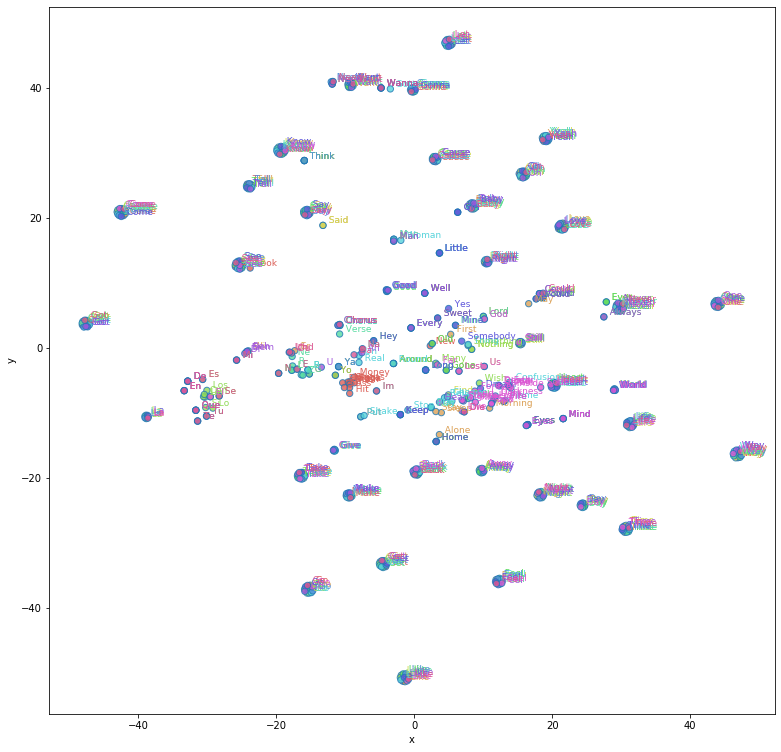

In [0]:
tsne_plot(df)

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

In [2]:
import pandas as pd

In [3]:
# Load the data
raw_data = pd.read_csv("380000-lyrics-from-metrolyrics.zip")

In [ ]:
raw_data.columns.values

In [ ]:
raw_data.shape

In [ ]:
print(raw_data.head(10))

In [ ]:
print(raw_data.shape)
data = raw_data.loc[raw_data["lyrics"].str.len() > 3]
print(data.shape)

In [0]:
# Let's first filter all songs with no genre (null or have "Not Available" genre)
data = data[data["genre"] != "Not Available"]
data = data[data["genre"].notnull()]
data

In [0]:
data['genre'].value_counts().plot.bar()

In [0]:
# Import LabelEncoder
from sklearn import preprocessing

# creating labelEncoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers.
genres_encoded = le.fit_transform(data["genre"].tolist())
genres_encoded

In [0]:
classes = list(le.classes_)
codes = le.transform(list(le.classes_))
for clss, code in zip(classes, codes):
  print(clss, code)

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

In [0]:
from sklearn.model_selection import train_test_split

# Split songs dataset to train, test and validation data
X_train, X_test, y_train, y_test = train_test_split(data["lyrics"],
                                                    genres_encoded, 
                                                    test_size=0.2,
                                                    random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=1)

In [0]:
X_train.shape

In [0]:
def clean_X(X):
    clean_X = []

    # Loop over each document; create an index i that goes from 0 to the length
    # of the train list 
    for i, val in X.iteritems():
        # Call our function for each one, and add the result to the list of clean reviews
        if ((i + 1) % 10000 == 0):
            print("Lyrics %d of %d\n" % (i + 1, X.size))
        clean_X.append(" ".join(document_to_words(val)))
  
    return clean_X

In [0]:
clean_X_train = clean_X(X_train)

In [0]:
clean_X_train[:3]

In [0]:
clean_X_test = clean_X(X_test)

In [0]:
def vectorize_features(X, vectorizer):
      # fit_transform() does two functions: First, it fits the model
      # and learns the vocabulary; second, it transforms our training data
      # into feature vectors. The input to fit_transform should be a list of 
      # strings.
    features = vectorizer.fit_transform(X)

      # Numpy arrays are easy to work with, so convert the result to an 
      # array
    features = features.toarray()
    return features

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None, 
                             preprocessor = None,
                             stop_words = None,
                             max_features = 15000) 

X_train_bows = vectorize_features(X_train, vectorizer)
X_test_bows = vectorize_features(X_test, vectorizer)

We're bound here by the power of our machines hardware. By increasing the `max_features` value in our vectorizers, we'll be able to get better precision. It seems that the fine rare words are the one that make som impact on classifying a song to its appropriate genre.

In [0]:
# See how the Vectorizer works
bows = vectorizer.fit_transform(['i eat the banana in the summer', 'in the spring i ate bananas'])
print(bows.toarray())
print(vectorizer.get_feature_names())

In [0]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

#Create a Gaussian Classifier
nbc = MultinomialNB()

#Train the model using the training sets
nbc.fit(X_train_bows, y_train)

In [0]:
#Predict the response for test dataset
y_pred = gnb.predict(X_test_bows)

Show the confusion matrix.

In [0]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

Show the classification report - precision, recall, f1 for each class.

In [0]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=classes))

### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [0]:
def avg_word_vector(X):
    avg_vectors = [];
    # todo: can be better implemented with numpy
    for i, val in X.iteritems():
        total_vector = np.zeros(model.vector_size)
        words = val.split(" ")
        for word in words:
            total_vector += model[word] if word in model.wv.vocab else np.zeros(model.vector_size) 
        avg_vector = total_vector / len(words)
        avg_vectors.append(avg_vector)
    return avg_vectors

In [0]:
X_train_avg_vc = avg_word_vector(X_train)
X_test_avg_vc = avg_word_vector(X_test)

In [0]:
from sklearn.preprocessing import StandardScaler  

scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train_avg_vc)  
X_train_avg_vc_scaled = scaler.transform(X_train_avg_vc)  
# apply same transformation to test data
X_test_avg_vc_scaled = scaler.transform(X_test_avg_vc) 

In [0]:
from sklearn.neural_network import MLPClassifier
 
clf = MLPClassifier(hidden_layer_sizes=(50,))

#Train the model using the training sets
clf.fit(X_train_avg_vc_scaled, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_avg_vc_scaled)

In [0]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

In [0]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=classes))

#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


In [0]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_mean_vectors(X):
    vectorizer = TfidfVectorizer(min_df=20)
    X_tfidf = vectorizer.fit_transform(X) 
    
    tfidf = X_tfidf.todense()
    # TFIDF of words not in the doc will be 0, so replace them with nan
    tfidf[tfidf == 0] = np.nan
    # Use nanmean of numpy which will ignore nan while calculating the mean
    X_tfidf_mean = np.nanmean(tfidf, axis=1)

    return X_tfidf_mean

In [0]:
X_tfidf = tfidf_mean_vectors(data["lyrics"])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf,
                                                    genres_encoded, 
                                                    test_size=0.2,
                                                    random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=1)

In [0]:
from sklearn.neural_network import MLPClassifier
 
clf = MLPClassifier(hidden_layer_sizes=(5,))

#Train the model using the training sets
clf.fit(X_train_tfidf, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_tfidf)

In [0]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

In [0]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=classes))

### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.

### Load the data

In [0]:
raw_data = pd.read_csv('380000-lyrics-from-metrolyrics.zip')

# filter out all data that is not null
data = raw_data[raw_data['lyrics'].notnull()]

Load our Word2Vec model. 

Add special word `<pad>` for padding the songs and add it to our w2v model

In [0]:
w2v_model = w2v_model = Word2Vec.load("300features_40minwords_10context.wv.model")

PAD = "<pad>"
w2v_model.wv["<pad>"] = np.zeros(300,)

In [0]:
import re
from nltk.corpus import stopwords

def process_document(text, remove_panctuations=True, 
                        remove_stopwords=True, remove_unknown_words=True, padding=128):
    
    if remove_panctuations:
      text = re.sub("[^a-zA-Z0-9]"," ", text)
    #
    # Convert words to lower case and split them
    words = text.lower().split()
    #
    # Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w.lower() in stops]  
        
    if remove_unknown_words:
        words = [w for w in words if w in w2v_model.wv]  
    
    if len(words) < padding:
        words += ([PAD] * (padding - len(words)))
    elif len(words) > padding:
        words = words[:padding]
        
#     processed_document = " ".join(words)
    return words

In [0]:
def tokenizer(text): # create a tokenizer function
    return process_document(text)

In [0]:
from sklearn.preprocessing import LabelBinarizer
ohe = LabelBinarizer()
ohe.fit_transform(data['genre'].values)

def one_hot_encoding(label):
    vec = ohe.transform([label])[0]
    return vec

In [0]:
from torch.utils.data import Dataset, DataLoader, random_split

class SongsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df):
        """
        Args:
            df (pandas.DataFrame): DataFrame object
        """
        self.texts = df['lyrics'].values
        self.labels = df['genre'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        text = tokenizer(text)
        text = [w2v_model.wv.vocab[word].index for word in text]
        label = self.labels[idx]
        label = one_hot_encoding(label)

        sample = (torch.tensor(text), torch.tensor(label, dtype=torch.float))

        return sample

In [0]:
dataset = SongsDataset(data)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

# let's see we have the data encoded to word indexes
dataset.__getitem__(99)

In [0]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)

### Functions to train and evaluate the model

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    probs = torch.softmax(preds, dim=1)
    winners = probs.argmax(dim=1)
    correct = (winners == y.argmax(dim=1)).float() #convert into float for division 

    acc = correct.sum() / len(correct)
    return acc

In [0]:
def train(model, loader, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
#     for batch in iterator:
    for index, batch in enumerate(loader):
        
        optimizer.zero_grad()
        
        predictions = model(batch[0]).squeeze(1)
        
        loss = criterion(predictions, batch[1])
        
        acc = binary_accuracy(predictions, batch[1])
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [0]:
def evaluate(model, loader, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
#         for batch in iterator:
        for index, batch in enumerate(loader):

            predictions = model(batch[0]).squeeze(1)
            
            loss = criterion(predictions, batch[1])
            
            acc = binary_accuracy(predictions, batch[1])

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Model defintion

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, out_channels, kernel_sizes, dropout, weights, 
                 freeze_embeddings=True):
        """
        Arguments
        ---------
        output_size : 2 = (pos, neg)
        in_channels : Number of input channels. Here it is 1 as the input data has dimension = (batch_size, num_seq, embedding_length)
        output_dim : Number of output channels after convolution operation performed on the input matrix (also number of filters)
        kernel_sizes : A list consisting of 3 different kernel_sizes. Convolution will be performed 3 times and finally results from each kernel_size will be concatenated.
        dropout : Probability of retaining an activation node during dropout operation
        vocab_size : Size of the vocabulary containing unique words
        embedding_dim : Embedding dimension of GloVe word embeddings
        weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table
        freeze_embeddings: Boolean flag to unfreeze the word embeddings weights
        --------
            
        """
        super(CNNClassifier, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.output_size = output_size
        self.out_channels = out_channels
        self.kernel_sizes = kernel_sizes
        
        if weights is not None:
            print(w2v_model.wv.vectors.shape)
            self.word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(weights), freeze=freeze_embeddings)
#             self.word_embeddings.weight = nn.Parameter(weights) # using pre-trained weights
#             self.word_embeddings.weight.requires_grad=unfreeze_embeddings
        else:
            self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels = 1,
                      out_channels = out_channels,
                      kernel_size = (embedding_dim, ks)
                     ) for ks in kernel_sizes
        ])

        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(len(kernel_sizes) * out_channels, output_size)

    def conv_block(self, input, conv_layer):
        conv_out = conv_layer(input) # conv_out.size() = (batch_size, out_channels, dim, 1)
        activation = F.relu(conv_out)
        activation = activation.squeeze(2) # activation.size() = (batch_size, out_channels, dim1)
        max_out = F.max_pool1d(activation, activation.size()[2]).squeeze(2) # maxpool_out.size() = (batch_size, out_channels)
        return max_out

    def forward(self, input_sentences, batch_size=None):
        # input_sentences.size() = (batch_size, num_seq)
        embedded = self.word_embeddings(input_sentences)
        # embedded.size() = (batch_size, num_seq, embedding_length)
        embedded = embedded.unsqueeze(1)
        # embedded.size() = (batch_size, 1, num_seq, embedding_length)
        embedded = embedded.permute(0, 1, 3, 2)
        # input.size() = (batch_size, 1, embedding_length, num_seq)
        max_out = [self.conv_block(embedded, conv) for conv in self.convs]
        #max_out = [batch size, out_channels]
        all_out = torch.cat(max_out, dim=1)
        # all_out.size() = (batch_size, num_kernels*out_channels)
        fc_in = self.dropout(all_out)
        # fc_in.size()) = (batch_size, num_kernels*out_channels)
        logits = self.fc(fc_in)
        # logits.size() = (batch_size, output_size)

        return logits

### Instantiate

In [0]:
NUM_CLASSES = 12 # 12 genres of songs
out_channels = 100
kernel_sizes = [3, 4, 5]
DROPOUT = 0.25
VOCAB_SIZE = len(w2v_model.wv.vocab)
EMBED_DIM = 300
weights =  w2v_model.wv.vectors #TEXT.vocab.vectors

model = CNNClassifier(vocab_size=VOCAB_SIZE, embedding_dim=EMBED_DIM, output_dim=NUM_CLASSES, 
                      out_channels=out_channels, kernel_sizes=kernel_sizes, dropout=DROPOUT, 
                      weights=weights)

### Split the data and run the model

In [0]:
import torch.optim as optim

N_EPOCHS = 5

optimizer = optim.Adam(model.parameters())
criterion = nn.MultiLabelSoftMarginLoss()

best_val_loss = float('inf')

all_train_losses = []
all_val_losses = []
train_accuracy = []
val_accuracy = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    all_train_losses += train_loss
    train_accuracy += train_acc

    val_loss, val_acc = evaluate(model, val_loader, criterion)
    all_val_losses += val_loss
    val_accuracy += val_acc
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

Let's plot our results

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses, 'r')
plt.plot(all_val_losses, 'g')
plt.plot(train_accuracy, 'b')
plt.plot(val_accuracy, 'y')
plt.show()